In [1]:
import numpy as np
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymultinest
import corner

from AxiScan import mc_gen
from AxiScan import scan
from AxiScan import axion_ll
from AxiScan import analysis_utilities

# Figure size
mpl.rcParams['figure.figsize'] = 20, 14

In [2]:
########################
###    Seed Values   ###
########################
c = 299798.452

# Physics Parameters
ma = 5.5e5*2*np.pi
A = 500.0
PSDback= 163539.36

# Expectation Parameters
v0_Exp = 220.0
vObs_Exp = 232.36

# Bulk SHM Parameters
v0_Halo = 220.0
vDotMag_Halo = 232.36
alpha_Halo = .49
tbar_Halo = 72.40

# Sagitarrius Stream Parameters
v0_Sub = 10.0
vDotMag_Sub = 418.815
alpha_Sub = .65903
tbar_Sub = 279.51
frac_Sub = 0.1

# Data Output Size
freqs = np.linspace(.99999, 1.00001, 500)*5.5e5
PSD_Data = np.zeros((365, len(freqs)))

collectionTime = 1/(freqs[1] - freqs[0])
stacked_per_day = 86400 / collectionTime
num_stacked = 365*stacked_per_day

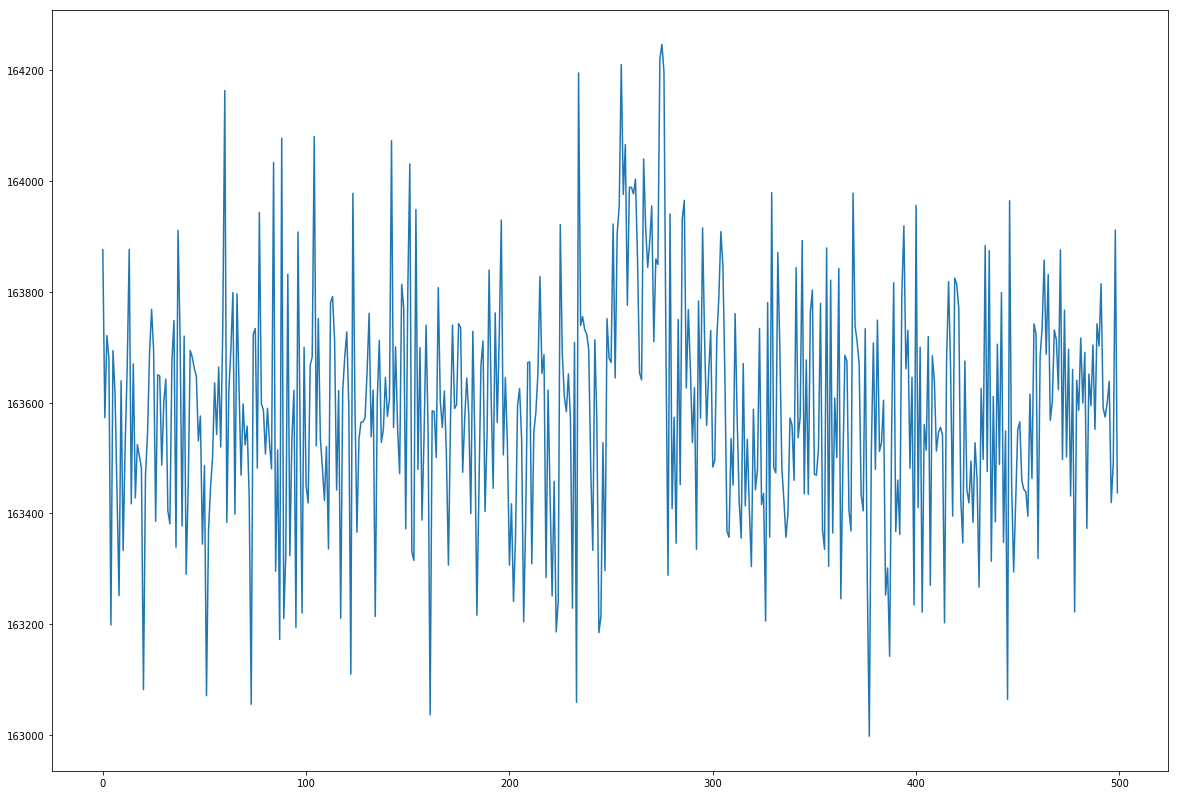

In [4]:
# Instantiate the data generator
generator = mc_gen.Generator(ma, A, PSDback, v0_Halo, vDotMag_Halo, alpha_Halo, tbar_Halo,
                             v0_Sub, vDotMag_Sub, alpha_Sub, tbar_Sub, frac_Sub, freqs)

# Fill the PSD_Data array
for i in range(365):
    PSD_Data[i] = np.array(generator.makePSD(i))
    
    
# Average over the days in the PSD_Data array for the coarse scan
Stacked_PSD_Data = np.mean(PSD_Data, axis = 0)

plt.plot(Stacked_PSD_Data)
plt.show()

In [5]:
# Construct the range of masses to scan over
N_testMass = int(np.log(freqs[-1] / freqs[0])  / np.log(1. + v0_Exp**2. / 2. / c**2.))-3
mass_TestSet = (freqs[0]*(1. + v0_Exp**2. / 2. / c**2.)**np.arange(N_testMass) * 2*np.pi)


# Construct the range of signal strengths to scan over
Sigma_A = analysis_utilities.getSigma_A(mass_TestSet, 365, 86400, v0_Exp, vObs_Exp, PSDback)
N_indMasses = 4 * c**2 / (3 * v0_Exp**2) * np.log(np.amax(freqs)/np.amin(freqs))
TS_Thresh = scipy.stats.norm.ppf(1 - (1-scipy.stats.norm.cdf(5))/N_indMasses)**2
detection_Threshold = np.sqrt(TS_Thresh)*Sigma_A

print(np.amax(detection_Threshold))

A_TestSet = np.linspace(-1, 10.0, 101)*np.amax(detection_Threshold)

# Run the Scan
TS_Array = np.array(scan.TS_Scan(Stacked_PSD_Data, freqs, mass_TestSet, A_TestSet, PSDback, v0_Exp, vObs_Exp, num_stacked))

299.514690272


In [6]:
A_Limits = np.zeros(mass_TestSet.shape) # The expected 95% constraint
A_Scans = np.zeros((mass_TestSet.shape)) # The TS maximizing value

for i in range(len(A_Limits)):
    # Naive TS maximizing value
    A_Scans[i] = A_TestSet[np.argmax(TS_Array[i])]
    
    # Extracting the 95% constraint by a shift in the TS of 2.71
    temp = np.copy(TS_Array[i])
    temp[0:np.nanargmax(temp)] = float('nan')
    temp -= np.nanmax(temp)
    A_Limits[i] = A_TestSet[analysis_utilities.find_nearest_index(temp, -2.706)]
    
A_Limits = np.maximum(A_Limits, analysis_utilities.zScore(-1)*Sigma_A)
A_Scans = np.maximum(0, A_Scans)

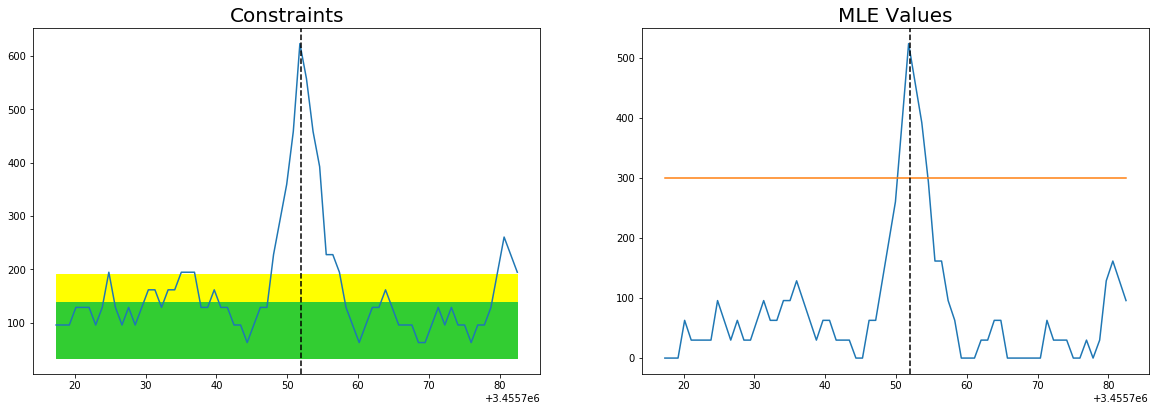

In [7]:
plt.subplot(2, 2, 1)
plt.title('Constraints', size = 20)
plt.plot(mass_TestSet, A_Limits)
plt.fill_between(mass_TestSet, analysis_utilities.zScore(-1)*Sigma_A, analysis_utilities.zScore(2)*Sigma_A, color = 'yellow')
plt.fill_between(mass_TestSet, analysis_utilities.zScore(-1)*Sigma_A, analysis_utilities.zScore(1)*Sigma_A, color = 'limegreen')
plt.axvline(x=ma, ls = '--', c = 'black')


plt.subplot(2, 2, 2)
plt.title('MLE Values', size = 20)
plt.plot(mass_TestSet, A_Scans)
plt.plot(mass_TestSet, detection_Threshold)
plt.axvline(x=ma, ls = '--', c = 'black')
plt.show()

In [8]:
##############################
###   Multinest Settings   ###
##############################

# Default multinest options
nlive = 500
chains_dir = '/nfs/turbo/bsafdi/fosterjw/github/AxiScan/examples/chains/'

pymultinest_options = {'importance_nested_sampling': False,
                        'resume': False, 'verbose': True,
                        'sampling_efficiency': 'model',
                        'init_MPI': False, 'evidence_tolerance': 0.5,
                        'const_efficiency_mode': False}

A_Prior = [.5*np.amax(A_Scans), 2*np.amax(A_Scans)]

theta_min = [A_Prior[0], ]
theta_max = [A_Prior[1]]


theta_interval = list(np.array(theta_max) - np.array(theta_min))
n_params = len(theta_min) # number of parameters to fit for

def prior_cube(cube, ndim=1, nparams=1):
    """ Cube of priors - in the format required by MultiNest
    """

    for i in range(ndim):
        cube[i] = cube[i] * theta_interval[i] + theta_min[i]
    return cube

def LL_Multinest(theta, ndim = 1, nparams = 1):
    return scan.SHM_AnnualMod_ll(freqs, PSD_Data, ma, theta[0], v0_Halo, vDotMag_Halo,
                                 alpha_Halo, tbar_Halo, PSDback, stacked_per_day)

In [9]:
pymultinest.run(LL_Multinest, prior_cube, n_params,
                outputfiles_basename=chains_dir,
                n_live_points=nlive, **pymultinest_options)

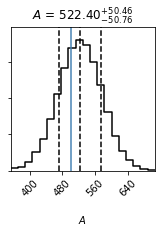

In [10]:
chain_file = '/nfs/turbo/bsafdi/fosterjw/github/AxiScan/examples/chains/post_equal_weights.dat'
chain = np.array(np.loadtxt(chain_file))[:, :-1]
# Now make a triangle plot using corner
corner.corner(chain, smooth=1.5, 
              labels = ['$A$', 'frac_Sub'], truths = [A, frac_Sub],
              smooth1d=1, quantiles=[0.16, 0.5, 0.84], show_titles=True,
              title_fmt='.2f', title_args={'fontsize': 14},
              range=[1 for _ in range(chain.shape[1])],
              plot_datapoints=False, verbose=False)

plt.show()